In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
npz1 = np.load(NPZ_DIR + '/20200816_CODEX_Panc.npz')
npz2 = np.load(NPZ_DIR + '/20200821_multiplex_normalized_512x512_train.npz')

combined_x = np.concatenate((npz1['X'], npz2['X']), axis=0)
combined_y = np.concatenate((npz1['y'], npz2['y']), axis=0)

In [4]:
combined_y.shape

(1136, 512, 512, 1)

In [5]:
from skimage.measure import label
for i in range(combined_y.shape[0]):
    combined_y[i, :, :, 0] = label(combined_y[i, :, :, 0])

In [4]:
# np.savez_compressed(NPZ_DIR + '/20200730_all_data_512x512.npz', X=combined_x, y=combined_y)

In [6]:
new_idx = np.random.choice(np.arange(1136), 1136, replace=False)

In [8]:
X_train, y_train = combined_x[new_idx], combined_y[new_idx]

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200908_multiplex_"

train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz")
val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz")
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

In [4]:
k=128
X_train = phase_preprocess(X_train, k)
X_val = phase_preprocess(X_val, k)

In [5]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, pixelwise
    location=True,  # should always be true
    include_top=True)

W0909 00:34:38.986356 140620559537984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + 'deep_watershed_beta_erosion'

n_epoch = 20  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 0  # throw out images with fewer than this many objects
seed=0
model_name

'20200908_multiplex_deep_watershed_beta_erosion'

In [ ]:
from deepcell import image_generators
from deepcell.utils import train_utils


#use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256),
    float_dtype='float16',
    int_dtype='int16')

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    float_dtype='float16',
    int_dtype='int16')    

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
#     transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
#     transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
#                       'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 5, 'alpha': 'auto', 'beta': 5}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    #     transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
#     transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
#                       'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 5, 'alpha': 'auto', 'beta': 5}},
    min_objects=min_objects,
    batch_size=batch_size)

W0909 00:36:45.999331 140620559537984 semantic.py:110] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype


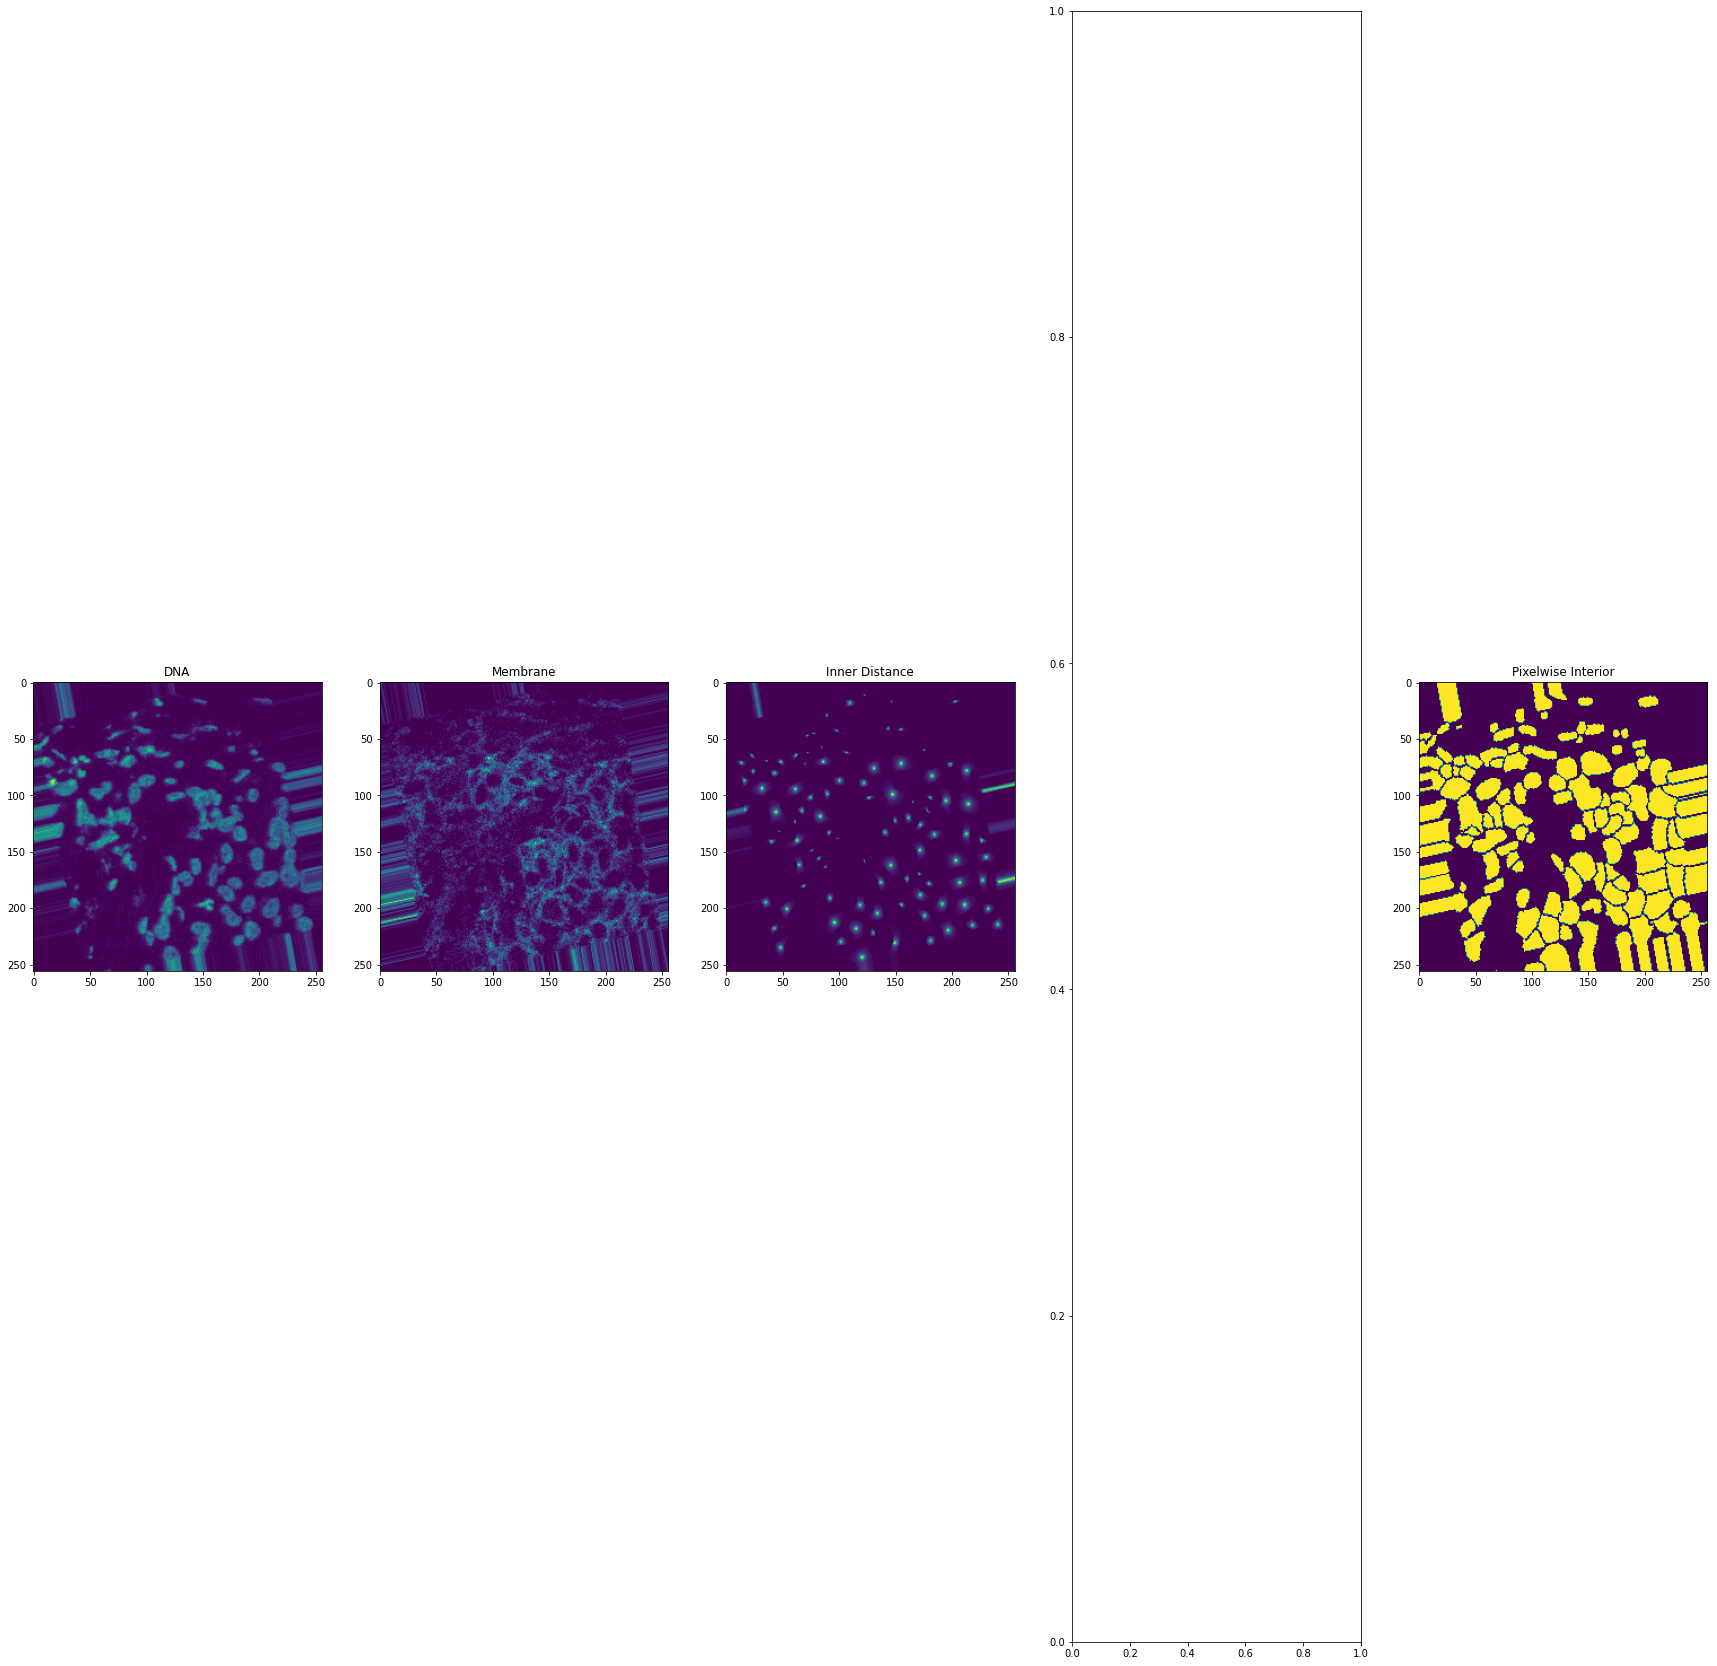

In [16]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
# outer_distance = outputs[1]
# fgbg = outputs[2]
pixelwise = outputs[1]

fig, axes = plt.subplots(1, 5, figsize=(30, 30))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('DNA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Membrane')

axes[2].imshow(inner_distance[0, ..., 0].astype('float32'))
axes[2].set_title('Inner Distance')

# axes[3].imshow(outer_distance[0, ..., 0].astype('float32'))
# axes[3].set_title('Outer Distance')

axes[4].imshow(pixelwise[0, ..., 1].astype('float32'))
axes[4].set_title('Pixelwise Interior')

plt.show()

In [17]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [18]:
new_model.compile(loss=loss, optimizer=optimizer)

In [20]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/20


W0909 00:28:13.116364 140166360889152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Error while reading resource variable batch_normalization_0_semantic_0/beta from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/batch_normalization_0_semantic_0/beta/N10tensorflow3VarE does not exist.
	 [[{{node batch_normalization_0_semantic_0/cond/ReadVariableOp_1}}]]
	 [[loss/Identity/_5639]]
  (1) Failed precondition: Error while reading resource variable batch_normalization_0_semantic_0/beta from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/batch_normalization_0_semantic_0/beta/N10tensorflow3VarE does not exist.
	 [[{{node batch_normalization_0_semantic_0/cond/ReadVariableOp_1}}]]
0 successful operations.
0 derived errors ignored.

In [6]:
new_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [33]:
test_dict = np.load(NPZ_DIR + npz_name + 'test_256x256.npz')
X_test = test_dict['X']
y_test = test_dict['y']
X_test = phase_preprocess(X_test, 128)

In [35]:
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation(use_pretrained_weights=False)

In [39]:
inner_distance, outer_distance, fgbg, pixelwise = new_model.predict(X_test)

In [66]:
small_idx = np.random.choice(range(X_test.shape[0]), 200, replace=False)

In [67]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance': inner_distance[small_idx],
                                     'pixelwise-interior': pixelwise[small_idx, :, :, 1:2]}, 
                                     maxima_threshold=0.02, maxima_model_smooth=0,
                                    interior_threshold=0.3,
                                    radius=5,
                                    small_objects_threshold=10,
                                     fill_holes_threshold=10)

In [43]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [68]:
RGB_data = make_color_overlay(X_test[small_idx, :, :, :])
true_overlay = make_outline_overlay(RGB_data, y_test[small_idx, :, :, 0])

In [69]:
predicted_overlay = make_outline_overlay(RGB_data, labeled_images[..., 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until
W0903 20:44:09.780683 140203977992000 image.py:716] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0903 20:44:09.783419 140203977992000 image.py:716] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


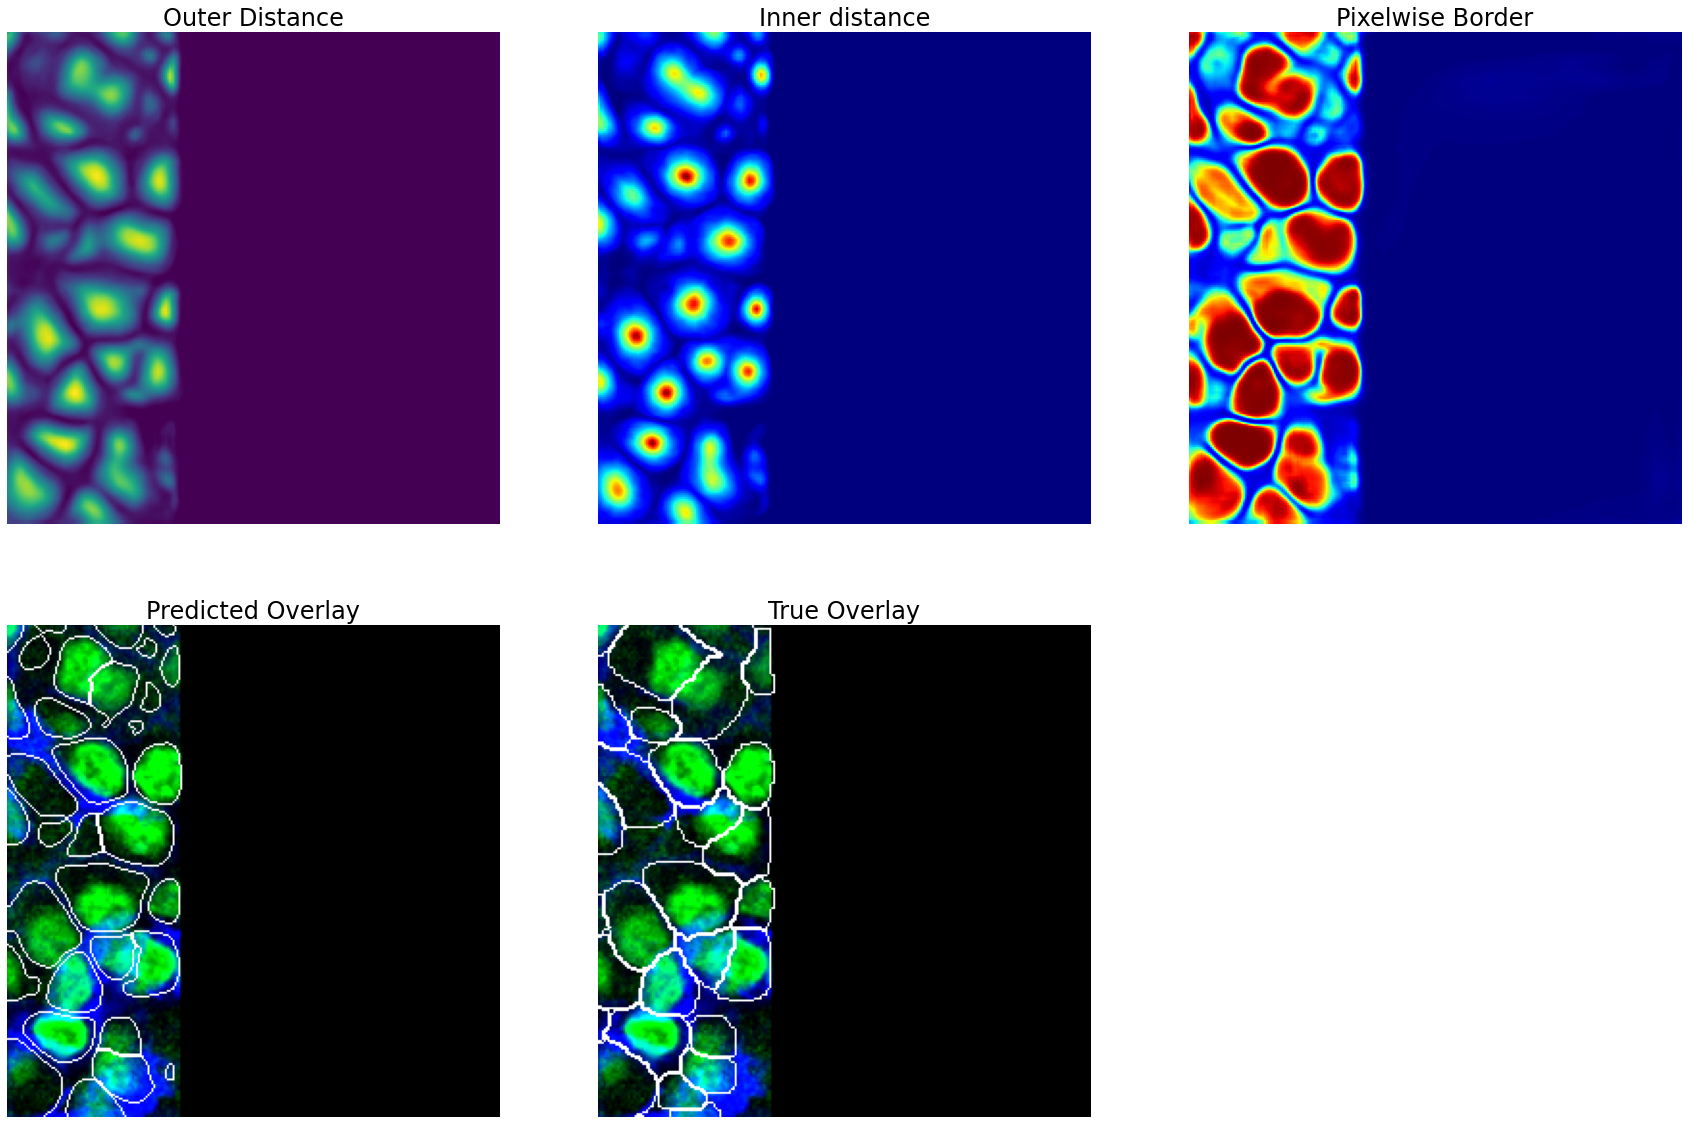

In [111]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 110
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(outer_distance[small_idx[index],..., 0])
axes[1].imshow(inner_distance[small_idx[index],...,0], cmap='jet')
axes[2].imshow(pixelwise[small_idx[index],...,1], cmap='jet')
axes[3].imshow(predicted_overlay[index, ...], cmap=cmap)
axes[4].imshow(true_overlay[index, ...], cmap=cmap)

axes[0].set_title('Outer Distance', fontsize=24)
axes[1].set_title('Inner distance', fontsize=24)
axes[2].set_title('Pixelwise Border', fontsize=24)
axes[3].set_title('Predicted Overlay', fontsize=24)
axes[4].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [39]:
len(np.unique(true[true == 5]))

0